In [37]:
!pip install pyscf ffsim qiskit_addon_sqd joblib


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [23]:
## STEP 1 : Mapping the problem

import pyscf
import pyscf.cc
import pyscf.mcscf

# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="6-31g",
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
exact_energy = cas.run().e_tot

# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run()
t1 = ccsd.t1
t2 = ccsd.t2

import ffsim
from qiskit import QuantumCircuit, QuantumRegister

n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()


converged SCF energy = -108.835236570774
CASCI E = -109.046671778080  E(CI) = -32.8155692383188  S^2 = 0.0000000
E(CCSD) = -109.0398256929733  E_corr = -0.20458912219883


In [24]:
circuit

In [25]:

## STEP 2 : Optimize Circuit
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

backend = service.backend("ibm_sherbrooke")

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

spin_a_layout = [0, 14, 18, 19, 20, 33, 39, 40, 41, 53, 60, 61, 62, 72, 81, 82]
spin_b_layout = [2, 3, 4, 15, 22, 23, 24, 34, 43, 44, 45, 54, 64, 65, 66, 73]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)

# without PRE_INIT passes
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes): {isa_circuit.count_ops()}")

# with PRE_INIT passes
# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")


Gate counts (w/o pre-init passes): OrderedDict({'rz': 4536, 'sx': 3419, 'ecr': 1366, 'x': 230, 'measure': 32, 'barrier': 1})
Gate counts (w/ pre-init passes): OrderedDict({'rz': 2481, 'sx': 2140, 'ecr': 730, 'x': 82, 'measure': 32, 'barrier': 1})


In [27]:

## STEP 3 : Execute

from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=100_000)

primitive_result = job.result()
pub_result = primitive_result[0]
counts = pub_result.data.meas.get_counts()


Starting configuration recovery iteration 0
Starting configuration recovery iteration 1


In [30]:

## STEP 4 : Post-process

from qiskit_addon_sqd.counts import counts_to_arrays

# Convert counts into bitstring and probability arrays
bitstring_matrix_full, probs_arr_full = counts_to_arrays(counts)

import numpy as np
from qiskit_addon_sqd.configuration_recovery import recover_configurations
from qiskit_addon_sqd.fermion import solve_fermion
from qiskit_addon_sqd.subsampling import postselect_and_subsample

rng = np.random.default_rng(12345)

# SQD options
iterations = 2

# Eigenstate solver options
n_batches = 3
samples_per_batch = 1000
max_davidson_cycles = 200

# Self-consistent configuration recovery loop
e_hist = np.zeros((iterations, n_batches))  # energy history
s_hist = np.zeros((iterations, n_batches))  # spin history
occupancy_hist = []
avg_occupancy = None
for i in range(iterations):
    print(f"Starting configuration recovery iteration {i}")
    # On the first iteration, we have no orbital occupancy information from the
    # solver, so we just post-select from the full bitstring set based on hamming weight.
    if avg_occupancy is None:
        bs_mat_tmp = bitstring_matrix_full
        probs_arr_tmp = probs_arr_full

    # If we have average orbital occupancy information, we use it to refine the full set of noisy configurations
    else:
        bs_mat_tmp, probs_arr_tmp = recover_configurations(
            bitstring_matrix_full,
            probs_arr_full,
            avg_occupancy,
            num_elec_a,
            num_elec_b,
            rand_seed=rng,
        )

    # Throw out configurations with incorrect particle number in either the spin-up or spin-down systems
    batches = postselect_and_subsample(
        bs_mat_tmp,
        probs_arr_tmp,
        hamming_right=num_elec_a,
        hamming_left=num_elec_b,
        samples_per_batch=samples_per_batch,
        num_batches=n_batches,
        rand_seed=rng,
    )

    # Run eigenstate solvers in a loop. This loop should be parallelized for larger problems.
    e_tmp = np.zeros(n_batches)
    s_tmp = np.zeros(n_batches)
    occs_tmp = []
    coeffs = []
    for j in range(n_batches):
        energy_sci, coeffs_sci, avg_occs, spin = solve_fermion(
            batches[j],
            hcore,
            eri,
            open_shell=open_shell,
            spin_sq=spin_sq,
            # max_davidson=max_davidson_cycles,
        )
        energy_sci += nuclear_repulsion_energy
        e_tmp[j] = energy_sci
        s_tmp[j] = spin
        occs_tmp.append(avg_occs)
        coeffs.append(coeffs_sci)

    # Combine batch results
    avg_occupancy = np.mean(occs_tmp, axis=0)

    # Track optimization history
    e_hist[i, :] = e_tmp
    s_hist[i, :] = s_tmp
    occupancy_hist.append(avg_occupancy)


Starting configuration recovery iteration 0
Starting configuration recovery iteration 1


In [31]:
occupancy_hist

[array([[9.99322531e-01, 9.93557279e-01, 3.64913527e-03, 9.97873116e-01,
         9.96376830e-01, 6.13546010e-03, 9.95590831e-01, 3.50607093e-04,
         2.85676719e-04, 5.12079872e-04, 1.61908132e-04, 1.42816734e-03,
         4.87454853e-04, 2.03304702e-04, 3.67292950e-03, 3.92689371e-04],
        [9.99322531e-01, 9.93557279e-01, 3.64913527e-03, 9.97873116e-01,
         9.96376830e-01, 6.13546010e-03, 9.95590831e-01, 3.50607093e-04,
         2.85676719e-04, 5.12079872e-04, 1.61908132e-04, 1.42816734e-03,
         4.87454853e-04, 2.03304702e-04, 3.67292950e-03, 3.92689371e-04]]),
 array([[0.99641648, 0.9916544 , 0.97252646, 0.9849216 , 0.99464108,
         0.01275555, 0.02434593, 0.00138293, 0.00124694, 0.00238663,
         0.00180452, 0.00281604, 0.00357363, 0.00433522, 0.0023777 ,
         0.0028149 ],
        [0.99641648, 0.9916544 , 0.97252646, 0.9849216 , 0.99464108,
         0.01275555, 0.02434593, 0.00138293, 0.00124694, 0.00238663,
         0.00180452, 0.00281604, 0.00357363, 

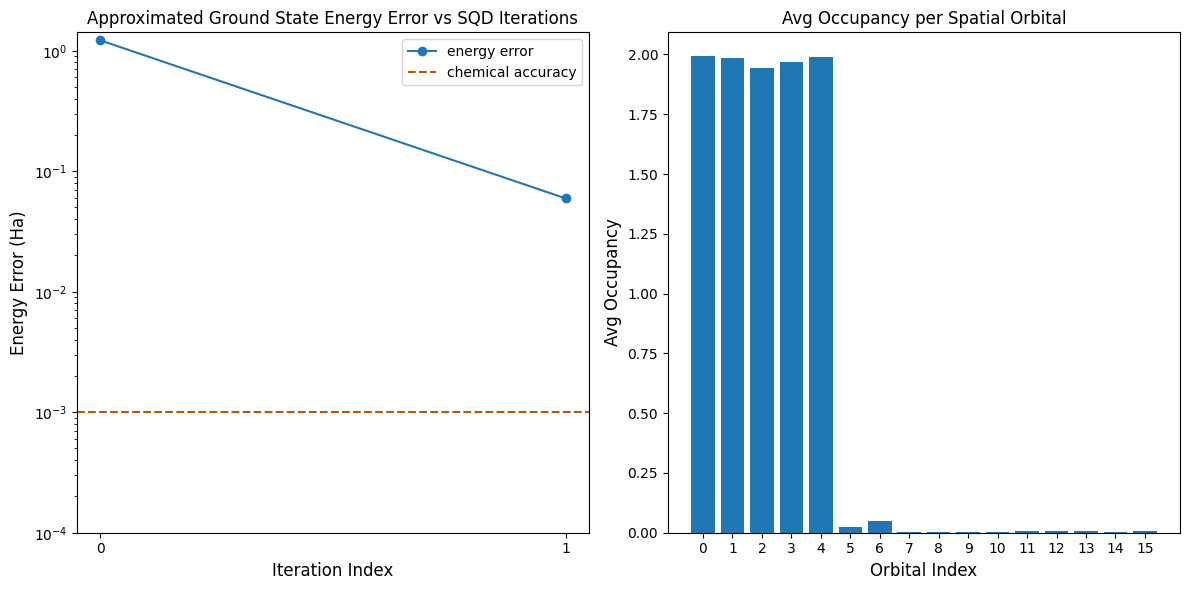

In [35]:
import matplotlib.pyplot as plt

# Data for energies plot
x1 = range(iterations)
e_diff = [abs(np.min(energies) - exact_energy) for energies in e_hist]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for avg spatial orbital occupancy
y2 = occupancy_hist[-1][0] + occupancy_hist[-1][1]
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

Starting SQD optimization with 3 batches and 10 iterations
Target exact energy: -109.04667178 Ha

=== Iteration 1/10 ===
  Using full bitstring matrix (first iteration)
  Post-selecting and subsampling...
    Subsampling took 0.00s
  Processing 3 batches...
    ✓ Batch 1: E = -107.82530467 Ha
    ✓ Batch 2: E = -107.82530467 Ha
    ✓ Batch 3: E = -107.82530467 Ha
    Batch processing took 5.58s
  Using simple average occupancy (low energy variation)
  Results: Mean E = -107.82530467 Ha (±0.00e+00)
  Range: [-107.82530467, -107.82530467] Ha
  Error from exact: 1.22e+00 Ha
  Iteration 1 completed in 5.58s

=== Iteration 2/10 ===
  Computing configuration recovery...
    Configuration recovery took 6.51s
  Post-selecting and subsampling...
    Subsampling took 0.01s
  Processing 3 batches...
    ✓ Batch 2: E = -108.98716350 Ha
    ✓ Batch 1: E = -108.95968968 Ha
    ✓ Batch 3: E = -108.97142829 Ha
    Batch processing took 12.50s
  Using simple average occupancy (low energy variation)
  O

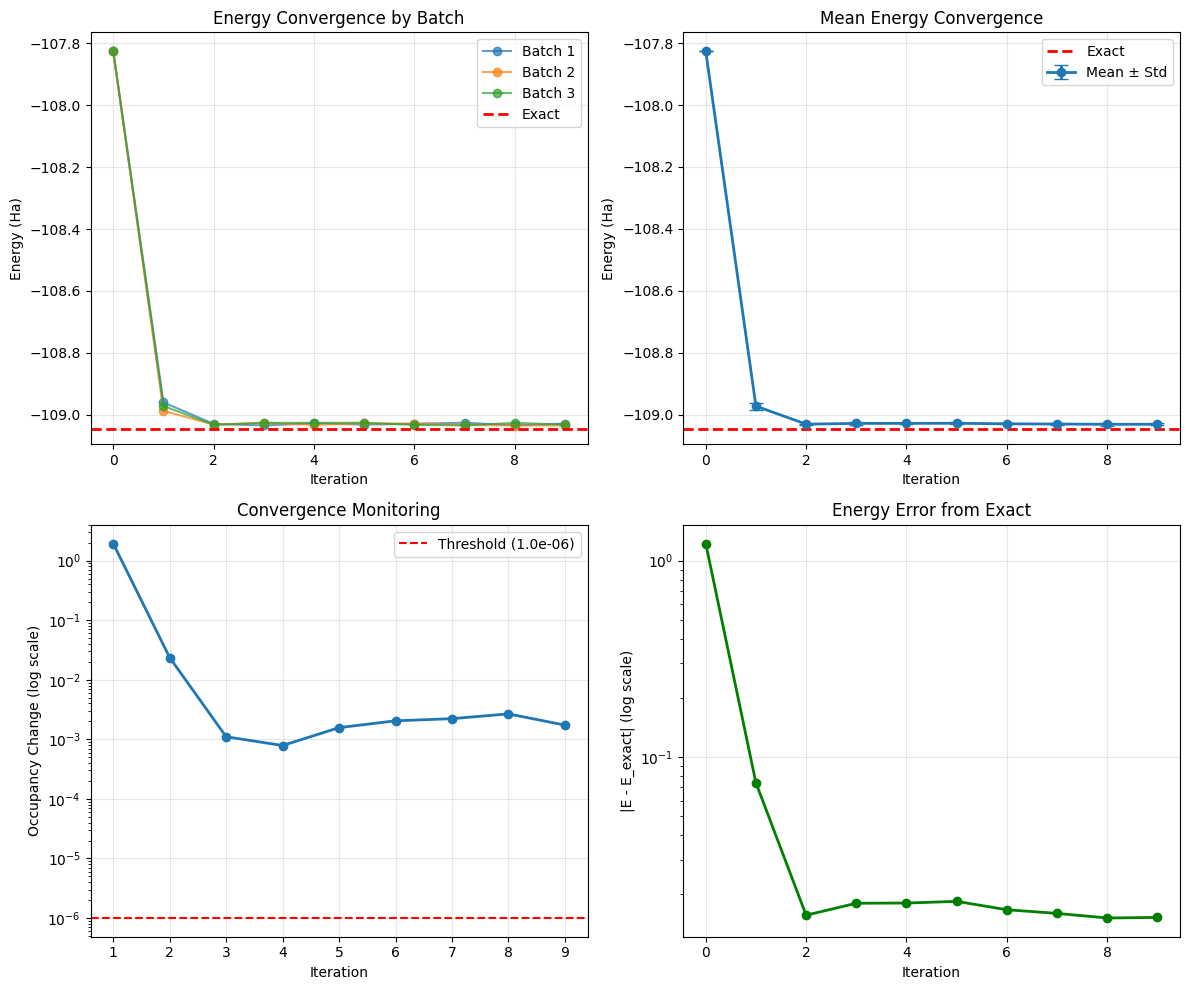

In [45]:
## STEP 4 : Post-process (Optimized - Fixed)

from qiskit_addon_sqd.counts import counts_to_arrays
import numpy as np
from qiskit_addon_sqd.configuration_recovery import recover_configurations
from qiskit_addon_sqd.fermion import solve_fermion
from qiskit_addon_sqd.subsampling import postselect_and_subsample
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
import time

# Convert counts into bitstring and probability arrays
bitstring_matrix_full, probs_arr_full = counts_to_arrays(counts)

rng = np.random.default_rng(12345)

# SQD options
iterations = 10

# Eigenstate solver options
n_batches = 3
samples_per_batch = 1000

class BatchProcessor:
    """Thread-safe batch processor for fermion solving"""
    
    def __init__(self, hcore, eri, nuclear_repulsion_energy, open_shell, spin_sq):
        self.hcore = hcore
        self.eri = eri
        self.nuclear_repulsion_energy = nuclear_repulsion_energy
        self.open_shell = open_shell
        self.spin_sq = spin_sq
        self.lock = threading.Lock()
    
    def solve_batch(self, batch_data):
        """Solve a single batch with thread safety"""
        batch, batch_idx = batch_data
        try:
            # Use thread-local storage for thread safety
            energy_sci, coeffs_sci, avg_occs, spin = solve_fermion(
                batch,
                self.hcore,
                self.eri,
                open_shell=self.open_shell,
                spin_sq=self.spin_sq,
            )
            energy_sci += self.nuclear_repulsion_energy
            return batch_idx, energy_sci, spin, avg_occs, coeffs_sci, None
        except Exception as e:
            return batch_idx, None, None, None, None, str(e)

def vectorized_occupancy_update(occs_list, energies, method='energy_weighted'):
    """
    Efficiently compute weighted average occupancy
    """
    if not occs_list:
        return None
    
    occs_array = np.array(occs_list)
    
    if method == 'simple':
        return np.mean(occs_array, axis=0)
    elif method == 'energy_weighted':
        # Normalize energies to prevent overflow
        energies = np.array(energies)
        energies_norm = (energies - np.min(energies)) / (np.max(energies) - np.min(energies) + 1e-10)
        weights = np.exp(-2 * energies_norm)  # Lower energy = higher weight
        weights /= np.sum(weights)
        return np.average(occs_array, axis=0, weights=weights)
    elif method == 'median':
        return np.median(occs_array, axis=0)
    else:
        return np.mean(occs_array, axis=0)

# Pre-allocate arrays for better memory efficiency
e_hist = np.zeros((iterations, n_batches))
s_hist = np.zeros((iterations, n_batches))
occupancy_hist = []

# Configuration recovery cache
config_cache = {}
cache_hits = 0

# Convergence tracking
convergence_threshold = 1e-6
occupancy_changes = []

avg_occupancy = None

# Create batch processor
processor = BatchProcessor(hcore, eri, nuclear_repulsion_energy, open_shell, spin_sq)

print(f"Starting SQD optimization with {n_batches} batches and {iterations} iterations")
print(f"Target exact energy: {exact_energy:.8f} Ha")

start_time = time.time()

for i in range(iterations):
    iter_start = time.time()
    print(f"\n=== Iteration {i+1}/{iterations} ===")
    
    # Configuration recovery with improved caching
    if avg_occupancy is None:
        bs_mat_tmp = bitstring_matrix_full
        probs_arr_tmp = probs_arr_full
        print("  Using full bitstring matrix (first iteration)")
    else:
        # Create robust cache key by flattening and rounding the occupancy array
        try:
            # Flatten the occupancy array and convert to hashable tuple
            occupancy_flat = np.array(avg_occupancy).flatten()
            cache_key = tuple(np.round(occupancy_flat, 8))  # Higher precision
            
            if cache_key in config_cache:
                bs_mat_tmp, probs_arr_tmp = config_cache[cache_key]
                cache_hits += 1
                print(f"  Using cached configuration recovery (cache hits: {cache_hits})")
            else:
                print("  Computing configuration recovery...")
                config_start = time.time()
                bs_mat_tmp, probs_arr_tmp = recover_configurations(
                    bitstring_matrix_full,
                    probs_arr_full,
                    avg_occupancy,
                    num_elec_a,
                    num_elec_b,
                    rand_seed=rng,
                )
                config_time = time.time() - config_start
                print(f"    Configuration recovery took {config_time:.2f}s")
                
                # Smart cache management
                if len(config_cache) >= 5:  # Limit cache size
                    # Remove oldest entry
                    oldest_key = next(iter(config_cache))
                    del config_cache[oldest_key]
                config_cache[cache_key] = (bs_mat_tmp, probs_arr_tmp)
                
        except Exception as cache_error:
            # Fallback: disable caching for this iteration if key creation fails
            print(f"  Cache key creation failed ({cache_error}), computing without cache...")
            config_start = time.time()
            bs_mat_tmp, probs_arr_tmp = recover_configurations(
                bitstring_matrix_full,
                probs_arr_full,
                avg_occupancy,
                num_elec_a,
                num_elec_b,
                rand_seed=rng,
            )
            config_time = time.time() - config_start
            print(f"    Configuration recovery took {config_time:.2f}s")

    # Post-selection and subsampling
    print("  Post-selecting and subsampling...")
    subsample_start = time.time()
    batches = postselect_and_subsample(
        bs_mat_tmp,
        probs_arr_tmp,
        hamming_right=num_elec_a,
        hamming_left=num_elec_b,
        samples_per_batch=samples_per_batch,
        num_batches=n_batches,
        rand_seed=rng,
    )
    subsample_time = time.time() - subsample_start
    print(f"    Subsampling took {subsample_time:.2f}s")

    # Batch processing with threading (safer than multiprocessing for this use case)
    batch_data = [(batches[j], j) for j in range(n_batches)]
    
    # Initialize arrays for this iteration
    e_tmp = np.zeros(n_batches)
    s_tmp = np.zeros(n_batches)
    occs_tmp = [None] * n_batches
    coeffs = [None] * n_batches
    errors = [None] * n_batches
    
    print(f"  Processing {n_batches} batches...")
    batch_start = time.time()
    
    # Use ThreadPoolExecutor instead of ProcessPoolExecutor
    max_workers = min(n_batches, 4)  # Limit concurrent threads
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all jobs
        future_to_batch = {
            executor.submit(processor.solve_batch, batch_data[j]): j 
            for j in range(n_batches)
        }
        
        # Collect results as they complete
        completed = 0
        for future in as_completed(future_to_batch):
            try:
                batch_idx, energy_sci, spin, avg_occs, coeffs_sci, error = future.result(timeout=300)  # 5 min timeout
                
                if energy_sci is not None:
                    e_tmp[batch_idx] = energy_sci
                    s_tmp[batch_idx] = spin
                    occs_tmp[batch_idx] = avg_occs
                    coeffs[batch_idx] = coeffs_sci
                    print(f"    ✓ Batch {batch_idx + 1}: E = {energy_sci:.8f} Ha")
                else:
                    errors[batch_idx] = error
                    print(f"    ✗ Batch {batch_idx + 1} failed: {error}")
                
                completed += 1
                
            except Exception as e:
                batch_idx = future_to_batch[future]
                errors[batch_idx] = str(e)
                print(f"    ✗ Batch {batch_idx + 1} failed with exception: {e}")
                completed += 1

    batch_time = time.time() - batch_start
    print(f"    Batch processing took {batch_time:.2f}s")

    # Analyze results
    valid_indices = [j for j in range(n_batches) if occs_tmp[j] is not None]
    failed_count = n_batches - len(valid_indices)
    
    if failed_count > 0:
        print(f"  Warning: {failed_count}/{n_batches} batches failed")
    
    if not valid_indices:
        print(f"  Critical: All batches failed in iteration {i+1}")
        if i > 0:  # Keep previous occupancy if available
            print("  Keeping previous occupancy values")
        continue
    
    # Compute occupancy update with multiple methods for robustness
    valid_occs = [occs_tmp[j] for j in valid_indices]
    valid_energies = [e_tmp[j] for j in valid_indices]
    
    # Try different averaging methods
    new_occupancy_weighted = vectorized_occupancy_update(valid_occs, valid_energies, 'energy_weighted')
    new_occupancy_simple = vectorized_occupancy_update(valid_occs, valid_energies, 'simple')
    
    # Use weighted average if energies vary significantly, otherwise use simple average
    energy_std = np.std(valid_energies)
    energy_mean = np.mean(valid_energies)
    
    if energy_std / abs(energy_mean) > 0.01:  # More than 1% relative variation
        avg_occupancy = new_occupancy_weighted
        print(f"  Using energy-weighted occupancy (energy std/mean: {energy_std/abs(energy_mean):.4f})")
    else:
        avg_occupancy = new_occupancy_simple
        print(f"  Using simple average occupancy (low energy variation)")
    
    # Track convergence
    if i > 0 and occupancy_hist[-1] is not None:
        occupancy_change = np.linalg.norm(avg_occupancy - occupancy_hist[-1])
        occupancy_changes.append(occupancy_change)
        print(f"  Occupancy change: {occupancy_change:.2e}")
        
        if occupancy_change < convergence_threshold:
            print(f"  Convergence achieved! (change < {convergence_threshold:.1e})")

    # Store results
    e_hist[i, :] = e_tmp
    s_hist[i, :] = s_tmp
    occupancy_hist.append(avg_occupancy.copy() if avg_occupancy is not None else None)
    
    # Iteration summary
    if valid_indices:
        mean_energy = np.mean(valid_energies)
        std_energy = np.std(valid_energies)
        min_energy = np.min(valid_energies)
        max_energy = np.max(valid_energies)
        error_from_exact = abs(mean_energy - exact_energy)
        
        print(f"  Results: Mean E = {mean_energy:.8f} Ha (±{std_energy:.2e})")
        print(f"  Range: [{min_energy:.8f}, {max_energy:.8f}] Ha")
        print(f"  Error from exact: {error_from_exact:.2e} Ha")
        
        # Early stopping if very close to exact
        if error_from_exact < 1e-6:
            print(f"  Excellent accuracy achieved! Stopping early.")
            break
    
    iter_time = time.time() - iter_start
    print(f"  Iteration {i+1} completed in {iter_time:.2f}s")

total_time = time.time() - start_time

print(f"\n{'='*50}")
print("OPTIMIZATION COMPLETED")
print(f"{'='*50}")
print(f"Total time: {total_time:.2f}s")
print(f"Cache efficiency: {cache_hits}/{iterations} hits")

# Final analysis
final_valid_indices = [j for j in range(n_batches) if not np.isnan(e_hist[-1, j]) and e_hist[-1, j] != 0]
if final_valid_indices:
    final_energies = e_hist[-1, final_valid_indices]
    final_mean = np.mean(final_energies)
    final_std = np.std(final_energies)
    final_error = abs(final_mean - exact_energy)
    
    print(f"\nFinal Results:")
    print(f"  Mean energy: {final_mean:.8f} ± {final_std:.2e} Ha")
    print(f"  Exact energy: {exact_energy:.8f} Ha")
    print(f"  Absolute error: {final_error:.2e} Ha")
    print(f"  Relative error: {final_error/abs(exact_energy):.2e}")
    
    # Convergence analysis
    if len(occupancy_changes) > 1:
        print(f"\nConvergence Analysis:")
        print(f"  Final occupancy change: {occupancy_changes[-1]:.2e}")
        if len(occupancy_changes) >= 3:
            recent_changes = occupancy_changes[-3:]
            if all(c < convergence_threshold * 10 for c in recent_changes):
                print(f"  Status: Well converged ✓")
            elif occupancy_changes[-1] < occupancy_changes[-2]:
                print(f"  Status: Converging ↓")
            else:
                print(f"  Status: May need more iterations ↑")

else:
    print("\nWarning: No valid final results obtained!")

# Optional: Simple convergence plot
try:
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Energy convergence
    for j in range(n_batches):
        valid_mask = ~np.isnan(e_hist[:, j]) & (e_hist[:, j] != 0)
        if np.any(valid_mask):
            axes[0,0].plot(np.where(valid_mask)[0], e_hist[valid_mask, j], 
                          'o-', alpha=0.7, label=f'Batch {j+1}')
    axes[0,0].axhline(exact_energy, color='red', linestyle='--', label='Exact', linewidth=2)
    axes[0,0].set_xlabel('Iteration')
    axes[0,0].set_ylabel('Energy (Ha)')
    axes[0,0].set_title('Energy Convergence by Batch')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Mean energy with error bars
    mean_energies = []
    std_energies = []
    for i in range(iterations):
        valid_e = e_hist[i, ~np.isnan(e_hist[i, :]) & (e_hist[i, :] != 0)]
        if len(valid_e) > 0:
            mean_energies.append(np.mean(valid_e))
            std_energies.append(np.std(valid_e) if len(valid_e) > 1 else 0)
        else:
            mean_energies.append(np.nan)
            std_energies.append(0)
    
    valid_iters = ~np.isnan(mean_energies)
    if np.any(valid_iters):
        axes[0,1].errorbar(np.where(valid_iters)[0], np.array(mean_energies)[valid_iters], 
                          yerr=np.array(std_energies)[valid_iters], 
                          fmt='o-', capsize=5, label='Mean ± Std', linewidth=2)
        axes[0,1].axhline(exact_energy, color='red', linestyle='--', label='Exact', linewidth=2)
        axes[0,1].set_xlabel('Iteration')
        axes[0,1].set_ylabel('Energy (Ha)')
        axes[0,1].set_title('Mean Energy Convergence')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
    
    # Occupancy change
    if occupancy_changes:
        axes[1,0].semilogy(range(1, len(occupancy_changes)+1), occupancy_changes, 'o-', linewidth=2)
        axes[1,0].axhline(convergence_threshold, color='red', linestyle='--', 
                         label=f'Threshold ({convergence_threshold:.1e})')
        axes[1,0].set_xlabel('Iteration')
        axes[1,0].set_ylabel('Occupancy Change (log scale)')
        axes[1,0].set_title('Convergence Monitoring')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    
    # Energy error from exact
    energy_errors = []
    for i in range(iterations):
        valid_e = e_hist[i, ~np.isnan(e_hist[i, :]) & (e_hist[i, :] != 0)]
        if len(valid_e) > 0:
            energy_errors.append(abs(np.mean(valid_e) - exact_energy))
        else:
            energy_errors.append(np.nan)
    
    valid_errors = ~np.isnan(energy_errors)
    if np.any(valid_errors):
        axes[1,1].semilogy(np.where(valid_errors)[0], np.array(energy_errors)[valid_errors], 
                          'o-', linewidth=2, color='green')
        axes[1,1].set_xlabel('Iteration')
        axes[1,1].set_ylabel('|E - E_exact| (log scale)')
        axes[1,1].set_title('Energy Error from Exact')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("Matplotlib not available for convergence plots")
except Exception as e:
    print(f"Plotting failed: {e}")

In [40]:
## STEP 4 : Post-process (Optimized)

from qiskit_addon_sqd.counts import counts_to_arrays
import numpy as np
from qiskit_addon_sqd.configuration_recovery import recover_configurations
from qiskit_addon_sqd.fermion import solve_fermion
from qiskit_addon_sqd.subsampling import postselect_and_subsample
from joblib import Parallel, delayed

# --- OPTIMIZATION 1: Pre-filter raw data ---
# Convert counts into bitstring and probability arrays
bitstring_matrix_full, probs_arr_full = counts_to_arrays(counts)

# Create boolean masks to find bitstrings with the correct number of electrons for each spin
# Qiskit layout is [spin_b | spin_a], so we check the first num_orbitals bits for spin_b (left)
# and the next num_orbitals bits for spin_a (right)
mask_elec_a = np.sum(bitstring_matrix_full[:, num_orbitals:], axis=1) == num_elec_a
mask_elec_b = np.sum(bitstring_matrix_full[:, :num_orbitals], axis=1) == num_elec_b

# Combine masks to find bitstrings with the correct particle number for both spins
valid_mask = mask_elec_a & mask_elec_b

# Create a smaller, pre-filtered pool of valid configurations
valid_bs_mat = bitstring_matrix_full[valid_mask]
valid_probs_arr = probs_arr_full[valid_mask]

print(f"Pre-filtering complete. Kept {len(valid_bs_mat)} / {len(bitstring_matrix_full)} configurations.")

# --- OPTIMIZATION 2: Parallelize the solver ---
# Define a helper function to be run in parallel for each batch
def process_batch(batch, hcore, eri, open_shell, spin_sq, nuclear_repulsion_energy):
    """Wrapper for solve_fermion to enable parallel execution."""
    energy_sci, coeffs_sci, avg_occs, spin = solve_fermion(
        batch,
        hcore,
        eri,
        open_shell=open_shell,
        spin_sq=spin_sq,
        # max_davidson=max_davidson_cycles,
    )
    energy_sci += nuclear_repulsion_energy
    return energy_sci, coeffs_sci, avg_occs, spin

# --- Main self-consistent loop using optimized components ---
rng = np.random.default_rng(12345)

# SQD options
iterations = 2

# Eigenstate solver options
n_batches = 3
samples_per_batch = 1000

# Self-consistent configuration recovery loop
e_hist = np.zeros((iterations, n_batches))
s_hist = np.zeros((iterations, n_batches))
occupancy_hist = []
avg_occupancy = None

for i in range(iterations):
    print(f"Starting configuration recovery iteration {i}")

    # On the first iteration, we work with the pre-filtered valid configurations.
    if avg_occupancy is None:
        bs_mat_tmp = valid_bs_mat
        probs_arr_tmp = valid_probs_arr
    # In subsequent iterations, use occupancy info to recover from the *valid* pool, not the full noisy set.
    else:
        bs_mat_tmp, probs_arr_tmp = recover_configurations(
            valid_bs_mat,
            valid_probs_arr,
            avg_occupancy,
            num_elec_a,
            num_elec_b,
            rand_seed=rng,
        )

    # Subsample from the current working set of configurations.
    # We no longer need post-selection here because the pool is already valid.
    # Note: postselect_and_subsample is still useful for its subsampling logic.
    batches = postselect_and_subsample(
        bs_mat_tmp,
        probs_arr_tmp,
        hamming_right=num_elec_a,  # Still needed to guide the function
        hamming_left=num_elec_b,   # Still needed to guide the function
        samples_per_batch=samples_per_batch,
        num_batches=n_batches,
        rand_seed=rng,
    )

    # Run eigenstate solvers in parallel using all available CPU cores (n_jobs=-1)
    # The 'with' statement is good practice for managing the parallelization pool
    with Parallel(n_jobs=-1) as parallel:
        results = parallel(
            delayed(process_batch)(
                batch, hcore, eri, open_shell, spin_sq, nuclear_repulsion_energy
            )
            for batch in batches
        )

    # Unpack the results from the parallel execution
    # `results` is a list of tuples: [(e1, c1, o1, s1), (e2, c2, o2, s2), ...]
    e_tmp, coeffs, occs_tmp, s_tmp = zip(*results)

    # Combine batch results
    avg_occupancy = np.mean(occs_tmp, axis=0)

    # Track optimization history
    e_hist[i, :] = e_tmp
    s_hist[i, :] = s_tmp
    occupancy_hist.append(avg_occupancy)

Pre-filtering complete. Kept 444 / 99998 configurations.
Starting configuration recovery iteration 0
Starting configuration recovery iteration 1


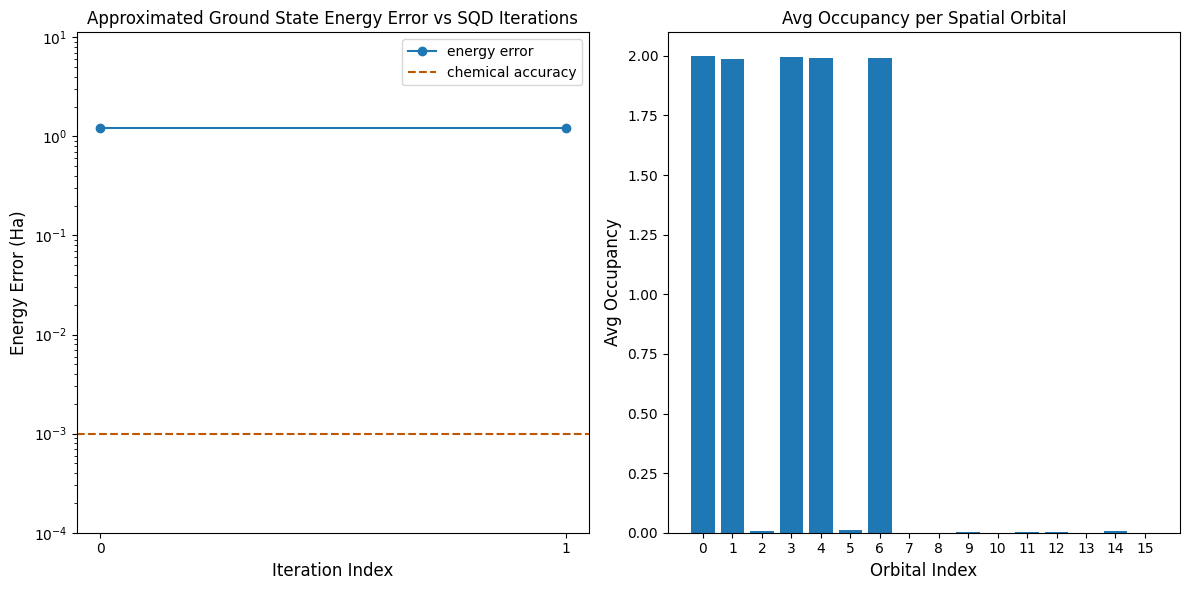

In [41]:
import matplotlib.pyplot as plt

# Data for energies plot
x1 = range(iterations)
e_diff = [abs(np.min(energies) - exact_energy) for energies in e_hist]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for avg spatial orbital occupancy
y2 = occupancy_hist[-1][0] + occupancy_hist[-1][1]
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()